# Sistemas de recomendación
En este proyecto se construirá un sistema de recomendación de películas utilizando la librería Surprise que permite crear y analizar este tipo de sistemas.
El dataset que se utilizará es la versión 100k de [MovieLens](http://grouplens.org/datasets/movielens/). MovieLens está basado en un sistema de rating de cinco estrellas y texto libre para tags. Contiene 100.000 ratings para 1.682 películas con datos creados por 943 usuarios, los cuales calificaron al menos 20 películas cada uno.

## Descripción de datos
### Ratings (u.data)
Cada línea representa el rating para una película y para un usuario. Los ratings están basados en un sistema de cinco estrellas, con un salto de 0.5 estrellas. Los timestamps están expresados en segundos desde la medianoche de 01/1970 (UTC). El formato es:

|user id | item id | rating | timestamp|

### Usuarios (u.users)
Cada línea del archivo representa un usuario, incluyendo información demográfica. Su formato es:

|user id | age | gender | occupation | zip code|

### Películas (u.item)
Cada línea corresponde a una película (puede existir inconsistencias en los nombres). El formato es:

|movie id | movie title | release date | video release date | IMDb URL | generos|

<br>Las columnas con los generos son binarias indicando la presencia o ausencia de cada uno en la película. Los géneros pueden ser:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* unknown

## Experimentación

Como se dijo anteriormente, durante todo este proyecto será utilizada la librería Surprise para llevar a cabo las experimentaciones. Surprise permite optimizar una mayor cantidad de parámetros comparado a estrategias convencionales como SVD (Singular value decomposition).

**Primero:** Para comenzar, se importa el Reader desde Surprise y configurando los parámetros 'line_format' igual a 'user item rating timestamp' y 'sep' igual a '\t' para poder leer la información:

In [1]:
from surprise import Dataset
from surprise import Reader
reader = Reader(line_format='user item rating timestamp', sep='\t')

y se cargan los datos:

In [2]:
data = Dataset.load_from_file('./dataset/ml-100k/u.data', reader=reader)

__Segundo:__ Se ejecuta una corrida inicial usando cross validation y el algoritmo SVD con 5 folds. Se imprimen los RMSE de testing:

In [3]:
from surprise import KNNBasic
from surprise.model_selection import cross_validate

knn = KNNBasic()
cv = cross_validate(knn, data, cv=5, measures=['RMSE'], verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9795  0.9787  0.9886  0.9719  0.9786  0.9795  0.0053  
Fit time          1.04    1.12    1.39    1.05    1.04    1.13    0.13    
Test time         8.63    8.43    8.36    9.04    8.28    8.55    0.27    


__Tercero:__ Se evalua el RMSE promedio del cross validation del conjunto de testing de acuerdo a la cantidad de factores en SVD:

In [4]:
import numpy as np
from surprise import SVD

rmse_test_means = []
factors = [1, 2, 3, 4, 5]

for factor in factors:
    knn = SVD(n_factors=factor)
    cv = cross_validate(knn, data, measures=['RMSE'],  cv=5)
    rmse_test_means.append(np.mean(cv['test_rmse']))

__Cuarto:__ Se grafican los promedios RMSE de testing de acuerdo a la cantidad de factores en SVD:

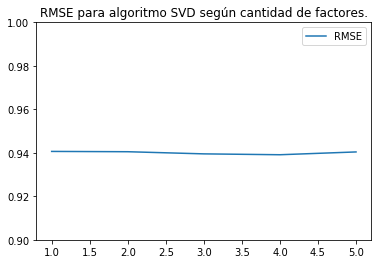

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(factors, rmse_test_means, label='RMSE')
plt.ylim((0.90, 1.0))
plt.legend(loc="best")
plt.title("RMSE para algoritmo SVD según cantidad de factores.")
plt.show()

__Quinto:__ Con GridSearch, se encuentra el mejor estimador para SVD con 500 factores y se imprimie el mejor rmse. Después se obtiene el mejor estimador ya ajustado como resultado.

El espacio de parámetros utilizado es:
* n_epochs: [5, 10]
* lr_all: [0.002, 0.005]
* reg_all: [0.4, 0.6]


In [6]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[500], 'n_epochs':[5, 10], 'lr_all':[0.002, 0.005], 
              'reg_all':[0.4, 0.6]}
grid = GridSearchCV(SVD, param_grid, measures=['RMSE'], cv=5, refit=True)
grid.fit(data)

In [7]:
print(grid.best_params['rmse'])

{'n_factors': 500, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [8]:
print(grid.best_score['rmse'])

0.9617775057093862


__Sexto:__ A continuación se obtiene una predicción para el usuario 321 para la película Titanic como ejemplo:

In [60]:
datos = Dataset.load_builtin('ml-100k')
train = datos.build_full_trainset()
test = train.build_anti_testset()

In [61]:
sim_options = {'name': 'cosine', 'user_based': True}
M = KNNBasic(sim_options=sim_options)
M.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [62]:
uid = '321'
iid = '313'
pred = M.predict(uid=uid, iid=iid, r_ui=None, verbose=True)

user: 321        item: 313        r_ui = None   est = 4.22   {'actual_k': 40, 'was_impossible': False}


__Septimo:__ Se desarrolla una función para la sigueinte situación: dado un usuario, se obtenga la mejor predicción disponible (recomendación), teniendo en cuenta los datos de las películas:

In [63]:
from collections import defaultdict

In [64]:
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [67]:
N = SVD()
N.fit(train)
predictions = N.test(test)
top_n = get_top_n(predictions, n=5)

In [68]:
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

196 ['318', '513', '98', '50', '127']
186 ['318', '64', '408', '641', '1137']
22 ['408', '64', '114', '189', '603']
244 ['187', '408', '134', '285', '513']
166 ['168', '223', '89', '483', '513']
298 ['251', '64', '12', '316', '223']
115 ['179', '14', '156', '408', '134']
253 ['169', '114', '408', '174', '251']
305 ['114', '513', '641', '498', '589']
6 ['603', '114', '1142', '198', '654']
62 ['187', '408', '223', '48', '480']
286 ['318', '12', '651', '192', '190']
200 ['272', '641', '251', '480', '12']
210 ['427', '169', '408', '513', '480']
224 ['174', '272', '496', '98', '64']
303 ['169', '513', '520', '205', '180']
122 ['178', '408', '272', '488', '169']
194 ['480', '169', '302', '963', '48']
291 ['474', '135', '127', '318', '169']
234 ['169', '408', '514', '114', '189']
119 ['488', '657', '479', '114', '483']
167 ['22', '69', '272', '98', '195']
299 ['178', '923', '427', '187', '64']
308 ['302', '114', '316', '474', '647']
95 ['318', '258', '603', '187', '251']
38 ['143', '174', '40

546 ['64', '251', '12', '483', '302']
522 ['174', '127', '64', '511', '178']
551 ['480', '750', '1449', '199', '528']
544 ['603', '511', '64', '483', '50']
553 ['180', '408', '192', '313', '357']
552 ['169', '603', '641', '513', '483']
540 ['408', '169', '483', '474', '127']
554 ['496', '64', '169', '114', '515']
550 ['169', '408', '427', '318', '357']
556 ['357', '483', '50', '251', '98']
559 ['251', '114', '483', '408', '657']
560 ['178', '408', '487', '64', '114']
561 ['134', '114', '408', '169', '340']
563 ['483', '22', '318', '479', '511']
566 ['474', '513', '603', '515', '169']
557 ['408', '114', '169', '64', '923']
558 ['603', '480', '357', '427', '963']
564 ['318', '169', '657', '513', '64']
565 ['427', '483', '408', '178', '318']
573 ['515', '64', '302', '408', '12']
549 ['408', '12', '479', '134', '272']
567 ['921', '488', '169', '709', '813']
569 ['408', '127', '199', '483', '134']
562 ['515', '178', '169', '1449', '603']
576 ['22', '199', '174', '134', '511']
577 ['169', '6